# Schroedinger Equation for Hydrogen Atom

Ref: [https://www.physics.rutgers.edu/~haule/509/ ](https://www.physics.rutgers.edu/~haule/509/)

The Schroedinger equation is:

$
(-\frac{\hbar^2}{2m}\nabla^2-\frac{Z e^2}{4\pi\varepsilon_0 r})\psi(\vec{r})=E \psi(\vec{r})
$

using ansatz:

$\psi(\vec{r}) = Y_{lm}(\hat{r})\; u(r)/r$

and introducing dimensionless variables:

$
x = \frac{r}{r_B}, \varepsilon = \frac{E}{E_0}
$
, where
$
r_B = \frac{4\pi\varepsilon_0 \hbar^2}{m e^2} \approx 0.529 A, E_0 = \frac{\hbar^2}{2 m r_B^2} == Ry \approx 13.6 eV
$

we get the differential equation

$$
u''(x)-
\left(\frac{l(l+1)}{x^2}-\frac{2Z}{x}-\varepsilon\right)u(x)=0
$$

Next we rewrite into the system of first order equations:

$$
y = \left(u(x),u'(x)\right)\\
\frac{dy}{dx} = \left(u'(x),u''(x)\right)
$$

with boundary conditions
$$
u(0) = 0 \rightarrow \psi(0)<\infty\\
u(\infty)=0 \rightarrow \int |\psi(r)|^2 r^2 dr \propto \int u^2(r)dr < \infty
$$

Because boundary conditions are given at the two ends, we need so-called shooting method

**Shooting algorithm:**

Suppose the two boundary condistions are given at $a$ and $b$, i.e., $u(a)=u(b)=0$. Then

* Choose $u(a)=0$ and $u'(a)=c$, with $c$ some constant.
* Solve for $u(x)$ to the other end, and check if $u(b)=0$.
* Using root finding routine find energy $\varepsilon$ for which u(b)=0. This is the bound state.
* Continue with increasing energy $\varepsilon$ until sufficient number of bound states is found

**Some remarks**

* It turns out that forward integration of the radial Sch. Eq. is unstable. It is better to start integrating from infinity, and then continue down to zero.
* It is better to use logarithmic mesh for radial variable rather than linear. Radial functions need smaller number of points in logarithmic mesh

**The implementation will follow these steps**

1. Call SciPy routine `integrate.odeint` to integrate the one-electron Schroedinger equation. Note that the distance is measured in units of bohr radius and energy units is Rydberg ($1\,\mathrm{Ry} = 13.6058\,\mathrm{eV}$).

2. The boundary conditions are $u(0)=0$ and $u(\infty)=0$.  
  Use shooting method to obtain wave functions:
  - Use logarithmic mesh of radial points for integration. Start integrating from a large distance ($R_{\mathrm{max}} \sim 100$). At $R_{\mathrm{max}}$ choose $u=0$ and some nonzero (not too large) derivative.
  - Integrate the Schroedinger equation down to $r=0$. If your choice for the energy $\varepsilon$ corresponds to the bound state, the wave function at $u(r=0)$ will be zero.

3. Start searching for the first bound state at sufficiently negative energy (for example $\sim -1.2 Z^2$) and increase energy in sufficiently small steps to bracket all necessary bound states. Once the wave function at $r=0$ changes sign, use root finding routine, for example `optimize.brentq`, to compute zero to very high precision. Store the index and the energy of the bound state for further processing.

4. Once bound state energies are found, recompute $u(r)$ for all bound states. Normalize $u(r)$ and plot them.

5. Compute electron density for various atoms (for example He, Li, ...) neglecting Coulomb repulsion:  
  Populate first $Z$ lowest laying electron states and compute
  $$
  \rho = \sum_{lm\,\in\,\mathrm{occupied}} \frac{u_{lm}^2(r)}{4\pi r^2}
  $$
  Each state with quantum number $l$ can take $2(2l+1)$ electrons. Be careful, if atom is not one of the noble gases (He, Ne, ...) the last orbital is only partially filled.


Recall: 
$$
\begin{aligned}
y &= (u(r), u'(r)) \\
\frac{dy}{dr} &= (u'(r), u''(r))
\end{aligned}
$$


$$
u''(r)=
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}-\varepsilon\right)u(r)
$$

In [18]:
import numpy as np
from scipy import integrate
from scipy import optimize

def Schroed_deriv(y,r,l,En):
    "Given y=[u,u'] returns dy/dr=[u',u''] "
    (u,up) = y
    return np.array([up, (l*(l+1)/r**2-2/r-En)*u])

First we try linear mesh and forward integration. It is supposed to be unstable.
We know the ground state has energy $E_0=-1 Ry$ and we should get $1s$ state with integrating Scroedinger equation. 

In [ ]:
R = np.linspace(1e-10,20,500)
l = 0
E0= -1.0 # the ground state, should give the first bound state.

u0 = 0.0
up0 = 1.0
ur = integrate.odeint(Schroed_deriv, [u0, up0], R, args=(l,E0)) 
# choice of derivative determines normalization, but not the shape of the wave functions.
print(ur)

[[ 0.00000000e+00  1.00000000e+00]
 [ 3.85055201e-02  9.22206818e-01]
 [ 7.39854187e-02  8.48982870e-01]
 [ 1.06618056e-01  7.80089075e-01]
 [ 1.36572393e-01  7.15298191e-01]
 [ 1.64008498e-01  6.54394181e-01]
 [ 1.89078033e-01  5.97171600e-01]
 [ 2.11924564e-01  5.43435235e-01]
 [ 2.32684081e-01  4.92999469e-01]
 [ 2.51485306e-01  4.45687901e-01]
 [ 2.68450064e-01  4.01332902e-01]
 [ 2.83693640e-01  3.59775184e-01]
 [ 2.97325098e-01  3.20863403e-01]
 [ 3.09447577e-01  2.84453801e-01]
 [ 3.20158606e-01  2.50409833e-01]
 [ 3.29550378e-01  2.18601816e-01]
 [ 3.37710020e-01  1.88906609e-01]
 [ 3.44719852e-01  1.61207293e-01]
 [ 3.50657629e-01  1.35392870e-01]
 [ 3.55596763e-01  1.11357994e-01]
 [ 3.59606560e-01  8.90026814e-02]
 [ 3.62752418e-01  6.82320591e-02]
 [ 3.65096032e-01  4.89561147e-02]
 [ 3.66695583e-01  3.10894635e-02]
 [ 3.67605918e-01  1.45511227e-02]
 [ 3.67878724e-01 -7.35702663e-04]
 [ 3.67562690e-01 -1.48438232e-02]
 [ 3.66703663e-01 -2.78422606e-02]
 [ 3.65344796e-01 -3

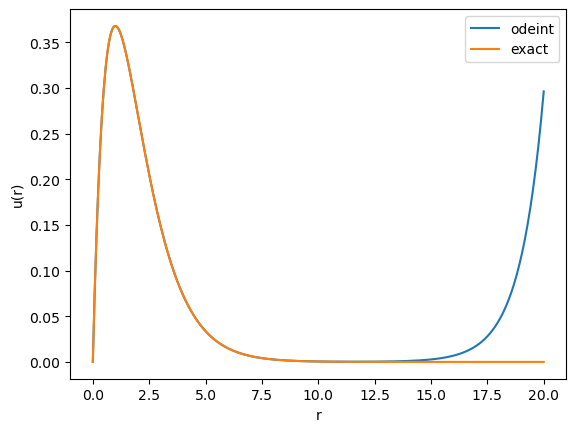

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(R,ur[:,0],label='odeint')
plt.plot(R,R*np.exp(-R),label='exact') # expected solution u = r * exp(-r)
plt.legend(loc='best')
plt.ylabel('u(r)')
plt.xlabel('r')
plt.show()

Indeed the integration is unstable, and needs to be done in opposite direction. Let's try from large R.

In [45]:
R = np.linspace(1e-10,20,500)
l = 0
E0 = -1.0
Rb = R[::-1] # invert the mesh

In [46]:

urb = integrate.odeint(Schroed_deriv, [0.0, -1e-7], Rb, args=(l,E0))
print(urb)
ur = urb[:,0][::-1]
norm = integrate.simpson(ur**2,x=R)
ur *= 1./np.sqrt(norm)

[[ 0.00000000e+00 -1.00000000e-07]
 [ 4.02434459e-09 -1.00076843e-07]
 [ 8.09056471e-09 -1.00308070e-07]
 [ 1.21989708e-08 -1.00694294e-07]
 [ 1.63495629e-08 -1.01235516e-07]
 [ 2.05423409e-08 -1.01931736e-07]
 [ 2.47773049e-08 -1.02782953e-07]
 [ 2.90544548e-08 -1.03789168e-07]
 [ 3.33737908e-08 -1.04950381e-07]
 [ 3.77353127e-08 -1.06266592e-07]
 [ 4.21390205e-08 -1.07737800e-07]
 [ 4.65849143e-08 -1.09364006e-07]
 [ 5.10729941e-08 -1.11145209e-07]
 [ 5.56032599e-08 -1.13081410e-07]
 [ 6.01757116e-08 -1.15172609e-07]
 [ 6.48046658e-08 -1.17425178e-07]
 [ 6.95659163e-08 -1.19872850e-07]
 [ 7.44705488e-08 -1.22520560e-07]
 [ 7.95185635e-08 -1.25368309e-07]
 [ 8.47099603e-08 -1.28416095e-07]
 [ 9.00447392e-08 -1.31663920e-07]
 [ 9.55229001e-08 -1.35111782e-07]
 [ 1.01144443e-07 -1.38759683e-07]
 [ 1.06909368e-07 -1.42607622e-07]
 [ 1.12817676e-07 -1.46655598e-07]
 [ 1.18869365e-07 -1.50903613e-07]
 [ 1.25064436e-07 -1.55351665e-07]
 [ 1.31402890e-07 -1.59999756e-07]
 [ 1.37884726e-07 -1

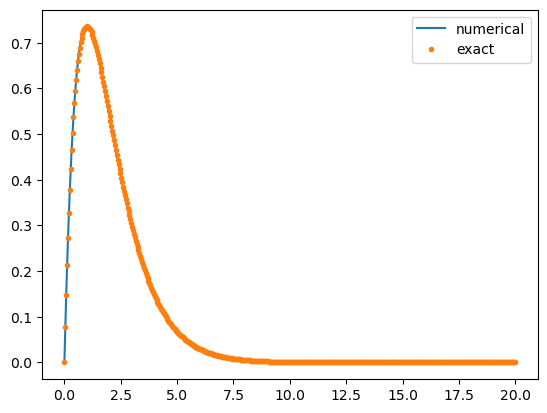

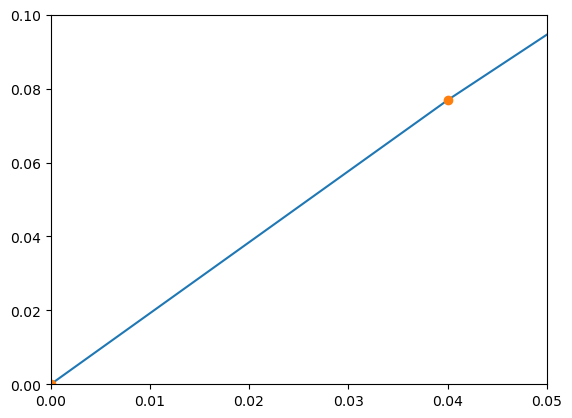

In [47]:
plt.plot(R,ur, label='numerical')
plt.plot(R, R*np.exp(-R)*2, '.', label='exact') # with proper normalization, exact solution is 2*r*exp(-r)
plt.legend(loc='best')
plt.show()

plt.plot(R,ur, '-')
plt.plot(R, R*np.exp(-R)*2, 'o')
plt.xlim(0,0.05)
plt.ylim(0,0.10)
plt.show()

Clearly the integration from infinity is stable, and we will use it here.

Logarithmic mesh is better suited for higher excited states, as they extend far away.

Lets create a subroutine of what we learned up to now:

In [48]:
def SolveSchroedinger(En,l,R):
    ur = integrate.odeint(Schroed_deriv, [0.0,-1e-7], R[::-1], args=(l,En))[:,0][::-1]
    ur *= 1./np.sqrt(integrate.simpson(ur**2,x=R))
    return ur

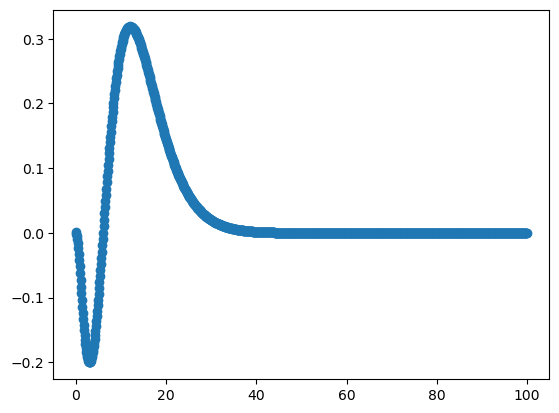

In [54]:
l=1
n=3
# E_n = -1/(n^2) in Ryberg units
En=-1./(n**2) # 3p orbital


#Ri = np.linspace(1e-6,20,500)   # linear mesh already fails for this case
Ri = np.linspace(1e-6,100,1000)
ui = SolveSchroedinger(En,l,Ri)
plt.plot(Ri,ui,'o-', label='linear');

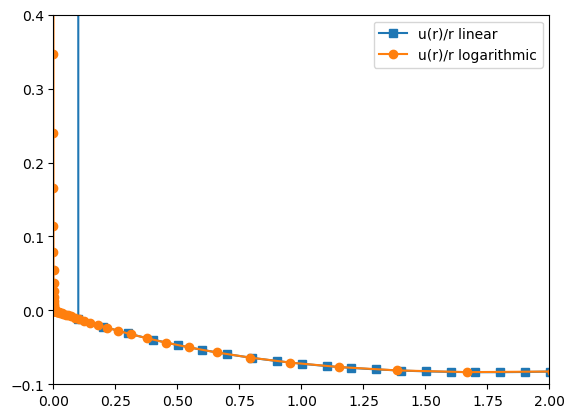

In [57]:
l=1
n=3
En=-1./(n**2)  # 3p orbital


#Ri = np.linspace(1e-6,20,500)   # linear mesh already fails for this case
Ri = np.linspace(1e-6,100,1000)
ui = SolveSchroedinger(En,l,Ri)


R = np.logspace(-6,2.,100)
ur = SolveSchroedinger(En,l,R)


#ylim([0,0.5])
plt.plot(Ri,ui/Ri,'s-', label='u(r)/r linear')
plt.plot(R,ur/R,'o-', label='u(r)/r logarithmic')
plt.xlim([0,2])
plt.ylim([-0.1,0.4])
plt.legend(loc='best');

**Shooting algorithm:**

The boundary condistions are given at two points $a$ and $b$, i.e., $u(a)=u(b)=0$. 

* **Choose $u(a)=0$ and $u'(a)=c$, with $c$ some constant.**
* **Solve for $u(x)$ to the other end, and evaluate $u(b)$.**

* Using root finding routine find energy $\varepsilon$ for which u(b)=0. This is the bound state.
* Continue with increasing energy $\varepsilon$ until sufficient number of bound states is found

In [ ]:
def Shoot(En,R,l):
    ur = integrate.odeint(Schroed_deriv, [0.0,-1e-7], R[::-1], args=(l,En))[:,0][::-1]
    norm=integrate.simpson(ur**2,x=R)# normalization is not essential here
    ur *= 1./np.sqrt(norm)            # once we normalize, the functions are all of the order of unity
    # we know that u(r)~ A r^(l+1), hence, u(r)/r^l ~ A r
    ur = ur/R**l
    # extrapolate to r=0
    f0 = ur[0]
    f1 = ur[1]
    f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
    return f_at_0 # = u(0)

In [71]:
R = np.logspace(-6,2.2,500)

Shoot(-1/9,R,0)

np.float64(3.496002818585823e-10)

**Shooting algorithm:**

The boundary condistions are given at two points $a$ and $b$, i.e., $u(a)=u(b)=0$. 

* Choose $u(a)=0$ and $u'(a)=c$, with $c$ some constant.
* Solve for $u(x)$ to the other end, and evaluate $u(b)$.

* **Using root finding routine find energy $\varepsilon$ for which u(b)=0. This is the bound state.**
* **Continue with increasing energy $\varepsilon$ until sufficient number of bound states is found**

In [73]:
def FindBoundStates(R,l,nmax,Esearch):
    """ R       -- real space mesh
        l       -- orbital quantum number
        nmax    -- maximum number of bounds states we require
        Esearch -- energy mesh, which brackets all bound-states, i.e., every sign change of the wave function at u(0).
    """
    n=0
    Ebnd=[] # save all bound states
    u0 = Shoot(Esearch[0],R,l)  # u(r=0) for the first energy Esearch[0]
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l) # evaluate u(r=0) and all Esearch points
        if u0*u1<0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,args=(R,l)) # root finding routine
            Ebnd.append((l,Ebound))
            if len(Ebnd)>nmax: break
            n+=1
            print(f"Found bound state at E={Ebound:14.9f} E_exact={-1.0/(n+l)**2:14.9f} l={l}")
        u0=u1
    
    return Ebnd

In [74]:
Esearch = -1.2/np.arange(1,20,0.2)**2
Esearch

array([-1.2       , -0.83333333, -0.6122449 , -0.46875   , -0.37037037,
       -0.3       , -0.24793388, -0.20833333, -0.17751479, -0.15306122,
       -0.13333333, -0.1171875 , -0.10380623, -0.09259259, -0.08310249,
       -0.075     , -0.06802721, -0.06198347, -0.05671078, -0.05208333,
       -0.048     , -0.0443787 , -0.04115226, -0.03826531, -0.03567182,
       -0.03333333, -0.03121748, -0.02929688, -0.02754821, -0.02595156,
       -0.0244898 , -0.02314815, -0.02191381, -0.02077562, -0.01972387,
       -0.01875   , -0.01784652, -0.0170068 , -0.01622499, -0.01549587,
       -0.01481481, -0.01417769, -0.01358081, -0.01302083, -0.01249479,
       -0.012     , -0.01153403, -0.01109467, -0.01067996, -0.01028807,
       -0.00991736, -0.00956633, -0.00923361, -0.00891795, -0.00861821,
       -0.00833333, -0.00806235, -0.00780437, -0.00755858, -0.00732422,
       -0.00710059, -0.00688705, -0.006683  , -0.00648789, -0.0063012 ,
       -0.00612245, -0.0059512 , -0.00578704, -0.00562957, -0.00

In [76]:
Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.logspace(-6,2.2,500)
nmax = 7

Bnd = []
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)

Found bound state at E=  -1.000000018 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249999997 E_exact=  -0.250000000 l=0
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=0
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=0
Found bound state at E=  -0.040000002 E_exact=  -0.040000000 l=0
Found bound state at E=  -0.027777773 E_exact=  -0.027777778 l=0
Found bound state at E=  -0.020409865 E_exact=  -0.020408163 l=0
Found bound state at E=  -0.249999997 E_exact=  -0.250000000 l=1
Found bound state at E=  -0.111111112 E_exact=  -0.111111111 l=1
Found bound state at E=  -0.062500001 E_exact=  -0.062500000 l=1
Found bound state at E=  -0.040000003 E_exact=  -0.040000000 l=1
Found bound state at E=  -0.027777889 E_exact=  -0.027777778 l=1
Found bound state at E=  -0.020421586 E_exact=  -0.020408163 l=1
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=2
Found bound state at E=  -0.062500001 E_exact=  -0.062500000 l=2
Found bound state at E=  

In [77]:
Bnd

[(0, -1.0000000175237493),
 (0, -0.24999999672119474),
 (0, -0.11111111116473228),
 (0, -0.06250000042496895),
 (0, -0.040000002241628314),
 (0, -0.02777777274566952),
 (0, -0.020409864997276275),
 (0, -0.015266291726552637),
 (1, -0.2499999966924928),
 (1, -0.1111111116193612),
 (1, -0.062500001453899),
 (1, -0.04000000294999121),
 (1, -0.02777788871547135),
 (1, -0.020421586294474957),
 (1, -0.015413169413305942),
 (2, -0.11111111126358458),
 (2, -0.06250000053821901),
 (2, -0.040000004196094376),
 (2, -0.02777851577949887),
 (2, -0.020414270711032384),
 (2, -0.015484354553456571),
 (3, -0.062499999809775046),
 (3, -0.04000000123306971),
 (3, -0.027778125963284318),
 (3, -0.020405511668886427),
 (3, -0.015519806412158195),
 (4, -0.03999999995489167),
 (4, -0.02777779850099035),
 (4, -0.020410582926254875),
 (4, -0.015576802781241763),
 (5, -0.027777787425088532),
 (5, -0.02040683257541746),
 (5, -0.015601410734180693)]

We have many bound states, but they are not properly sorted in order in which to fill atomic shells.

In [78]:
sorted(Bnd, key= lambda x: x[1])

[(0, -1.0000000175237493),
 (0, -0.24999999672119474),
 (1, -0.2499999966924928),
 (1, -0.1111111116193612),
 (2, -0.11111111126358458),
 (0, -0.11111111116473228),
 (1, -0.062500001453899),
 (2, -0.06250000053821901),
 (0, -0.06250000042496895),
 (3, -0.062499999809775046),
 (2, -0.040000004196094376),
 (1, -0.04000000294999121),
 (0, -0.040000002241628314),
 (3, -0.04000000123306971),
 (4, -0.03999999995489167),
 (2, -0.02777851577949887),
 (3, -0.027778125963284318),
 (1, -0.02777788871547135),
 (4, -0.02777779850099035),
 (5, -0.027777787425088532),
 (0, -0.02777777274566952),
 (1, -0.020421586294474957),
 (2, -0.020414270711032384),
 (4, -0.020410582926254875),
 (0, -0.020409864997276275),
 (5, -0.02040683257541746),
 (3, -0.020405511668886427),
 (5, -0.015601410734180693),
 (4, -0.015576802781241763),
 (3, -0.015519806412158195),
 (2, -0.015484354553456571),
 (1, -0.015413169413305942),
 (0, -0.015266291726552637)]

If energies are not degenerate, this would work. But for degenerate case, we need more careful sorting!

In [80]:
def cmpKey(x):
    return x[1] + x[0]/10000.  # energy has large wait, but degenerate energy states are sorted by l

Bnd = sorted(Bnd, key=cmpKey)

In [81]:
Bnd

[(0, -1.0000000175237493),
 (0, -0.24999999672119474),
 (1, -0.2499999966924928),
 (0, -0.11111111116473228),
 (1, -0.1111111116193612),
 (2, -0.11111111126358458),
 (0, -0.06250000042496895),
 (1, -0.062500001453899),
 (2, -0.06250000053821901),
 (3, -0.062499999809775046),
 (0, -0.040000002241628314),
 (1, -0.04000000294999121),
 (2, -0.040000004196094376),
 (3, -0.04000000123306971),
 (4, -0.03999999995489167),
 (0, -0.02777777274566952),
 (1, -0.02777788871547135),
 (2, -0.02777851577949887),
 (3, -0.027778125963284318),
 (4, -0.02777779850099035),
 (5, -0.027777787425088532),
 (0, -0.020409864997276275),
 (1, -0.020421586294474957),
 (2, -0.020414270711032384),
 (3, -0.020405511668886427),
 (4, -0.020410582926254875),
 (5, -0.02040683257541746),
 (1, -0.015413169413305942),
 (2, -0.015484354553456571),
 (0, -0.015266291726552637),
 (3, -0.015519806412158195),
 (4, -0.015576802781241763),
 (5, -0.015601410734180693)]

Now the states are sorted as expected in periodic table.

Now let's try to compute the charge density for a heavier atom, example of Ni.

In [83]:
Z=46 # like Ni
N=0
rho=np.zeros(len(R))
for (l,En) in Bnd:
    ur = SolveSchroedinger(En,l,R)
    dN = 2*(2*l+1) # each radial function can store these many electrons
    if N+dN<=Z:
        ferm = 1.  # no fractional occupancy needed
    else:
        ferm = (Z-N)/float(dN)  # fractional occupancy, because the orbital is not fully filled
    drho = ur**2 * ferm * dN/(4*np.pi*R**2) # charge density per solid angle per radius: drho/(dOmega*dr)
    rho += drho
    N += dN
    print(f'adding state ({l:2d},{En:14.9f}) with fermi={ferm:4.2f} and current N={N:5.1f}')
    if N>=Z: break

adding state ( 0,  -1.000000018) with fermi=1.00 and current N=  2.0
adding state ( 0,  -0.249999997) with fermi=1.00 and current N=  4.0
adding state ( 1,  -0.249999997) with fermi=1.00 and current N= 10.0
adding state ( 0,  -0.111111111) with fermi=1.00 and current N= 12.0
adding state ( 1,  -0.111111112) with fermi=1.00 and current N= 18.0
adding state ( 2,  -0.111111111) with fermi=1.00 and current N= 28.0
adding state ( 0,  -0.062500000) with fermi=1.00 and current N= 30.0
adding state ( 1,  -0.062500001) with fermi=1.00 and current N= 36.0
adding state ( 2,  -0.062500001) with fermi=1.00 and current N= 46.0


Resulting charge density for a Ni-like Hydrogen atom

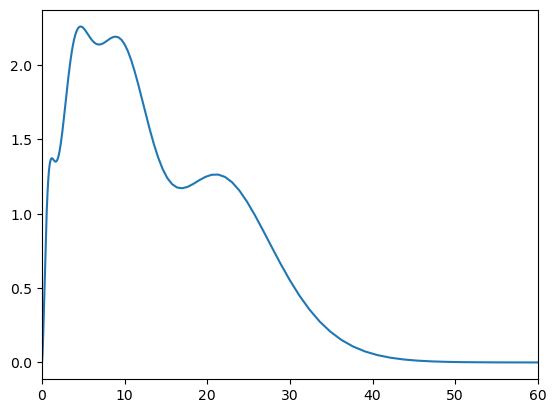

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(R,rho*4*np.pi*R**2,label='charge density')
plt.xlim([0,60])
plt.show()

In [30]:
integrate.simpson(rho*R**2 * 4*np.pi,x=R)  # total density

np.float64(46.0)

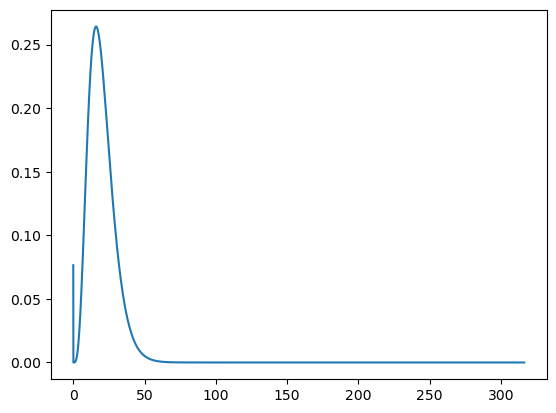

In [31]:
l=3
En=-1/4**2
#l,En = Bnd[9]
#R = np.logspace(-6,2,1000)
R = np.logspace(-2,2.5,1000)
ur = SolveSchroedinger(En,l,R)

plt.plot(R,ur,'-');

It seems that error accumulation still prevents one to calculate f-states near the nucleus. Only if we start sufficiently away from nucleus (0.1$R_b$) numerics works.

Can we do better?


## Numerov algorithm

The general purpose integration routine is not the best method for solving the Schroedinger equation, which does not have first derivative terms. 

Numerov algorithm is better fit for such equations, and its algorithm is summarized below. 

The second order linear differential equation (DE) of the form

$$
 x''(t) = f(t) x(t) + u(t)
 $$

is a target of Numerov algorithm.

Due to a special structure of the DE, the fourth order error cancels
and leads to sixth order algorithm using second order integration
scheme.


If we expand x(t) to some higher power and take into account the time
reversal symmetry of the equation, all odd term cancel

$$
  x(h) = x(0)+h x'(0)+\frac{1}{2}h^2 x''(0)+\frac{1}{3!}h^3
  x^{(3)}(0)+\frac{1}{4!}h^4 x^{(4)}(0)+\frac{1}{5!}h^5 x^{(5)}(0)+...\\
  x(-h) = x(0)-h x'(0)+\frac{1}{2}h^2 x''(0)-\frac{1}{3!}h^3
  x^{(3)}(0)+\frac{1}{4!}h^4 x^{(4)}(0)-\frac{1}{5!}h^5
  x^{(5)}(0)+...
$$

hence 

$$
  x(h)+x(-h) = 2x(0)+h^2 (f(0)x(0)+u(0))+\frac{2}{4!}h^4 x^{(4)}(0)+O(h^6)
$$


If we are happy with $O(h^4)$ algorithm, we can neglect $x^{(4)}$ term and
get the following recursion relation

$$
  x_{i+1} = 2 x_i - x_{i-1} + h^2 (f_i x_i+u_i) +O(h^4).
$$
where we renamed

$$
\begin{aligned}
&x_{i-1}&= x(-h)\\
&x_i  &= x(0)\\
&x_{i+1} &= x(h)
\end{aligned}
$$



But we know from the differential equation that

$$
  x^{(4)} = \frac{d^2 x''(t)}{dt^2} = \frac{d^2}{dt^2}(f(t) x(t)+u(t))
$$
and we will use the well known descrete expression for the second order derivative
$$
g''(t) = \frac{g(t+h) - 2 g(t) + g(t-h)}{h^2} + O(h^2)
$$
which can be approximated by

$$
  x^{(4)}= \frac{f_{i+1}x_{i+1}+u_{i+1}-2 f_i x_i -2 u_i+ f_{i-1}x_{i-1}+u_{i-1}}{h^2} + O(h^2)
$$

Inserting the fourth order derivative into the above recursive equation (forth equation in this chapter), we
get

$$
  x_{i+1}-2 x_i+x_{i-1}=h^2(f_i x_i+u_i)+\frac{h^2}{12}(f_{i+1}x_{i+1}+u_{i+1}-2 f_i x_i -2 u_i+ f_{i-1}x_{i-1}+u_{i-1}) + O(h^6)
$$

If we switch to a new variable $w_i=x_i(1-\frac{h^2}{12} f_i)-\frac{h^2}{12}u_i$
we are left with the following
equation

$$
  w_{i+1} = 2 w_i - w_{i-1} + h^2 (f_i x_i + u_i)+O(h^6)
$$

The variable $x$ needs to be recomputed at each step with
$$
x_i=\frac{w_i+\frac{h^2}{12}u_i}{1-\frac{h^2}{12}f_i}.
$$



In [7]:
def Numerovc(f, x0, dx, dh): # integrate.odeint
    """Given precomputed function f(x), solves for x(t), which satisfies:
          x''(t) = f(t) x(t)
          dx = (dx(t)/dt)_{t=0}
          x0 = x(t=0)
    """
    x = np.zeros(len(f))
    x[0] = x0
    x[1] = x0+dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0=x0*(1-h12*f[0])
    w1=x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,f.size):
        w2 = 2*w1-w0+h2*fi*xi  # here fi,xi=f1,x1 at the first step
        fi = f[i]              # at this point fi=f2 in the first step
        xi = w2/(1-h12*fi)     # xi is not x2 in the first step
        x[i]=xi                # save x2 into x[2]
        w0,w1 = w1,w2
    return x

For Numerov algorithm we can evaluate derivative part $f(r)$ for all points at once:

Because Schroedinger Eq is:
$$
u''(r)=
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}-\varepsilon\right)u(r)
$$

the $f$ function is
$$
f(r)=
\left(\frac{l(l+1)}{r^2}-\frac{2Z}{r}-\varepsilon\right)
$$

In [8]:
def fSchrod(En, l, R):
    return l*(l+1.)/R**2-2./R-En

The Numerov algorithm is much faster, but the price we pay is the mesh has to be linear. We can not use logarithmic mesh in combination with Numerov algorithm.

In [9]:
import numpy as np
import scipy.integrate as integrate
Rl = np.linspace(1e-6,100,1000)
l,En=0,-1 # 1s En = -1
f = fSchrod(En,l,Rl[::-1])     # here we turn mesh R around, so that f is given from large r down to r=0.
uinf = 0.0
ur = Numerovc(f,uinf,1e-7,Rl[1]-Rl[0])[::-1] # turn around the solution, so that it starts with r=0
norm = integrate.simpson(ur**2,x=Rl)
ur *= 1/np.sqrt(abs(norm))

In [20]:
# Let's compare the timing between Numerov and odeint
import numpy as np
import scipy.integrate as integrate
Rl = np.linspace(1e-6,100,1000)
l,En=0,-1 # 1s En = -1
f = fSchrod(En,l,Rl[::-1])     # here we turn mesh R around, so that f is given from large r down to r=0.
uinf = 0.0
%timeit ur = Numerovc(f,uinf,1e-7,Rl[1]-Rl[0])  

# odeint
from scipy import integrate

l,En=0,-1 # 1s En = -1

%timeit ur2 = integrate.odeint(Schroed_deriv, [0.0,-1e-7], Rl[::-1], args=(l,En))[:,0]

216 μs ± 1.52 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
866 μs ± 7.45 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


(0.0, 10.0)

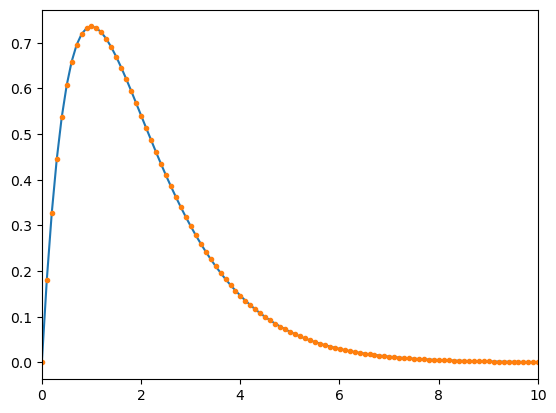

In [15]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.plot(Rl,np.exp(-Rl)*Rl*2.,'-')
plt.plot(Rl,ur,'.')
plt.xlim(0,10)

Numerov seems much more precise than odeint, and avoids numerical problems we had before

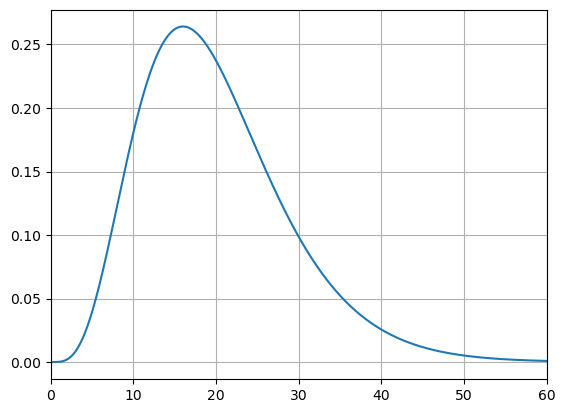

In [16]:
Rl = np.linspace(1e-6,100,1000)
l,En=3,-1/4**2
f = fSchrod(En,l,Rl[::-1])     # here we turn mesh R around, so that f is given from large r down to r=0.
ur = Numerovc(f,0.0,1e-7,Rl[1]-Rl[0])[::-1] # turn around the solution, so that it starts with r=0
norm = integrate.simpson(ur**2,x=Rl)
ur *= 1/np.sqrt(abs(norm))

plt.plot(Rl,ur,'-')
plt.xlim(0,60)
plt.grid()

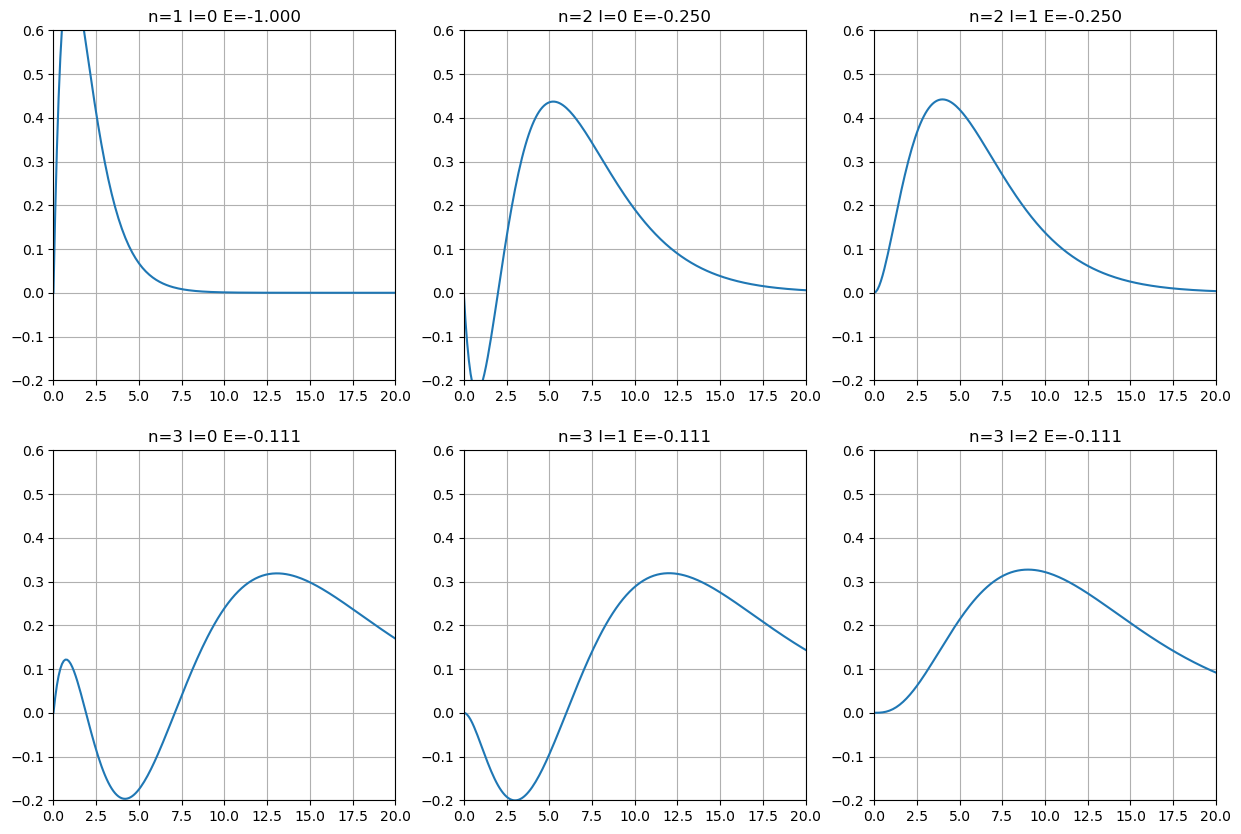

In [24]:
Rl = np.linspace(1e-6,100,1000)

# Let's plot n=1,2,3 l=0,1,2,..n-1

nmax = 3

#total number of plots = nmax*(nmax+1)/2
nplots = nmax*(nmax+1)//2 # 1s, 2s, 2p, 3s, 3p, 3d, ... -> 6 plots for nmax=3
ncol = 3
nrow = (nplots+ncol-1)//ncol

plt.subplots(nrow,ncol,figsize=(15,5*nrow))
for n in range(1,nmax+1):
    for l in range(0,n):
        En = -1./n**2
        f = fSchrod(En,l,Rl[::-1])     # here we turn mesh R around, so that f is given from large r down to r=0.
        ur = Numerovc(f,0.0,1e-7,Rl[1]-Rl[0])[::-1] # turn around the solution, so that it starts with r=0
        norm = integrate.simpson(ur**2,x=Rl)
        ur *= 1/np.sqrt(abs(norm))
        iplot = (n*(n-1))//2 + l + 1
        plt.subplot(nrow,ncol,iplot)
        plt.plot(Rl,ur,'-')
        plt.title(f'n={n} l={l} E={En:6.3f}')
        plt.xlim(0,20)
        plt.ylim(-0.2,0.6)
        plt.grid()
plt.show()

# # E_n = -1/n^2 in Rydberg units
# l, En = 0,-1/3**2   # 3p orbital

# f = fSchrod(En,l,Rl[::-1])
# ur = Numerovc(f,0.0,-1e-7,-Rl[1]+Rl[0])[::-1]
# norm = integrate.simpson(ur**2,x=Rl)
# ur *= 1/np.sqrt(abs(norm))

# plt.plot(Rl,ur, label='u(r)')
# plt.plot(Rl,ur/Rl, label='u(r)/r')
# plt.legend(loc='best')
# plt.show()

/var/folders/h3/b296rhks2f133q2fygydjy1m0000gn/T/ipykernel_82832/2730649517.py:22: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  r = np.abs(sph_harm(m, l, phi, theta))**2


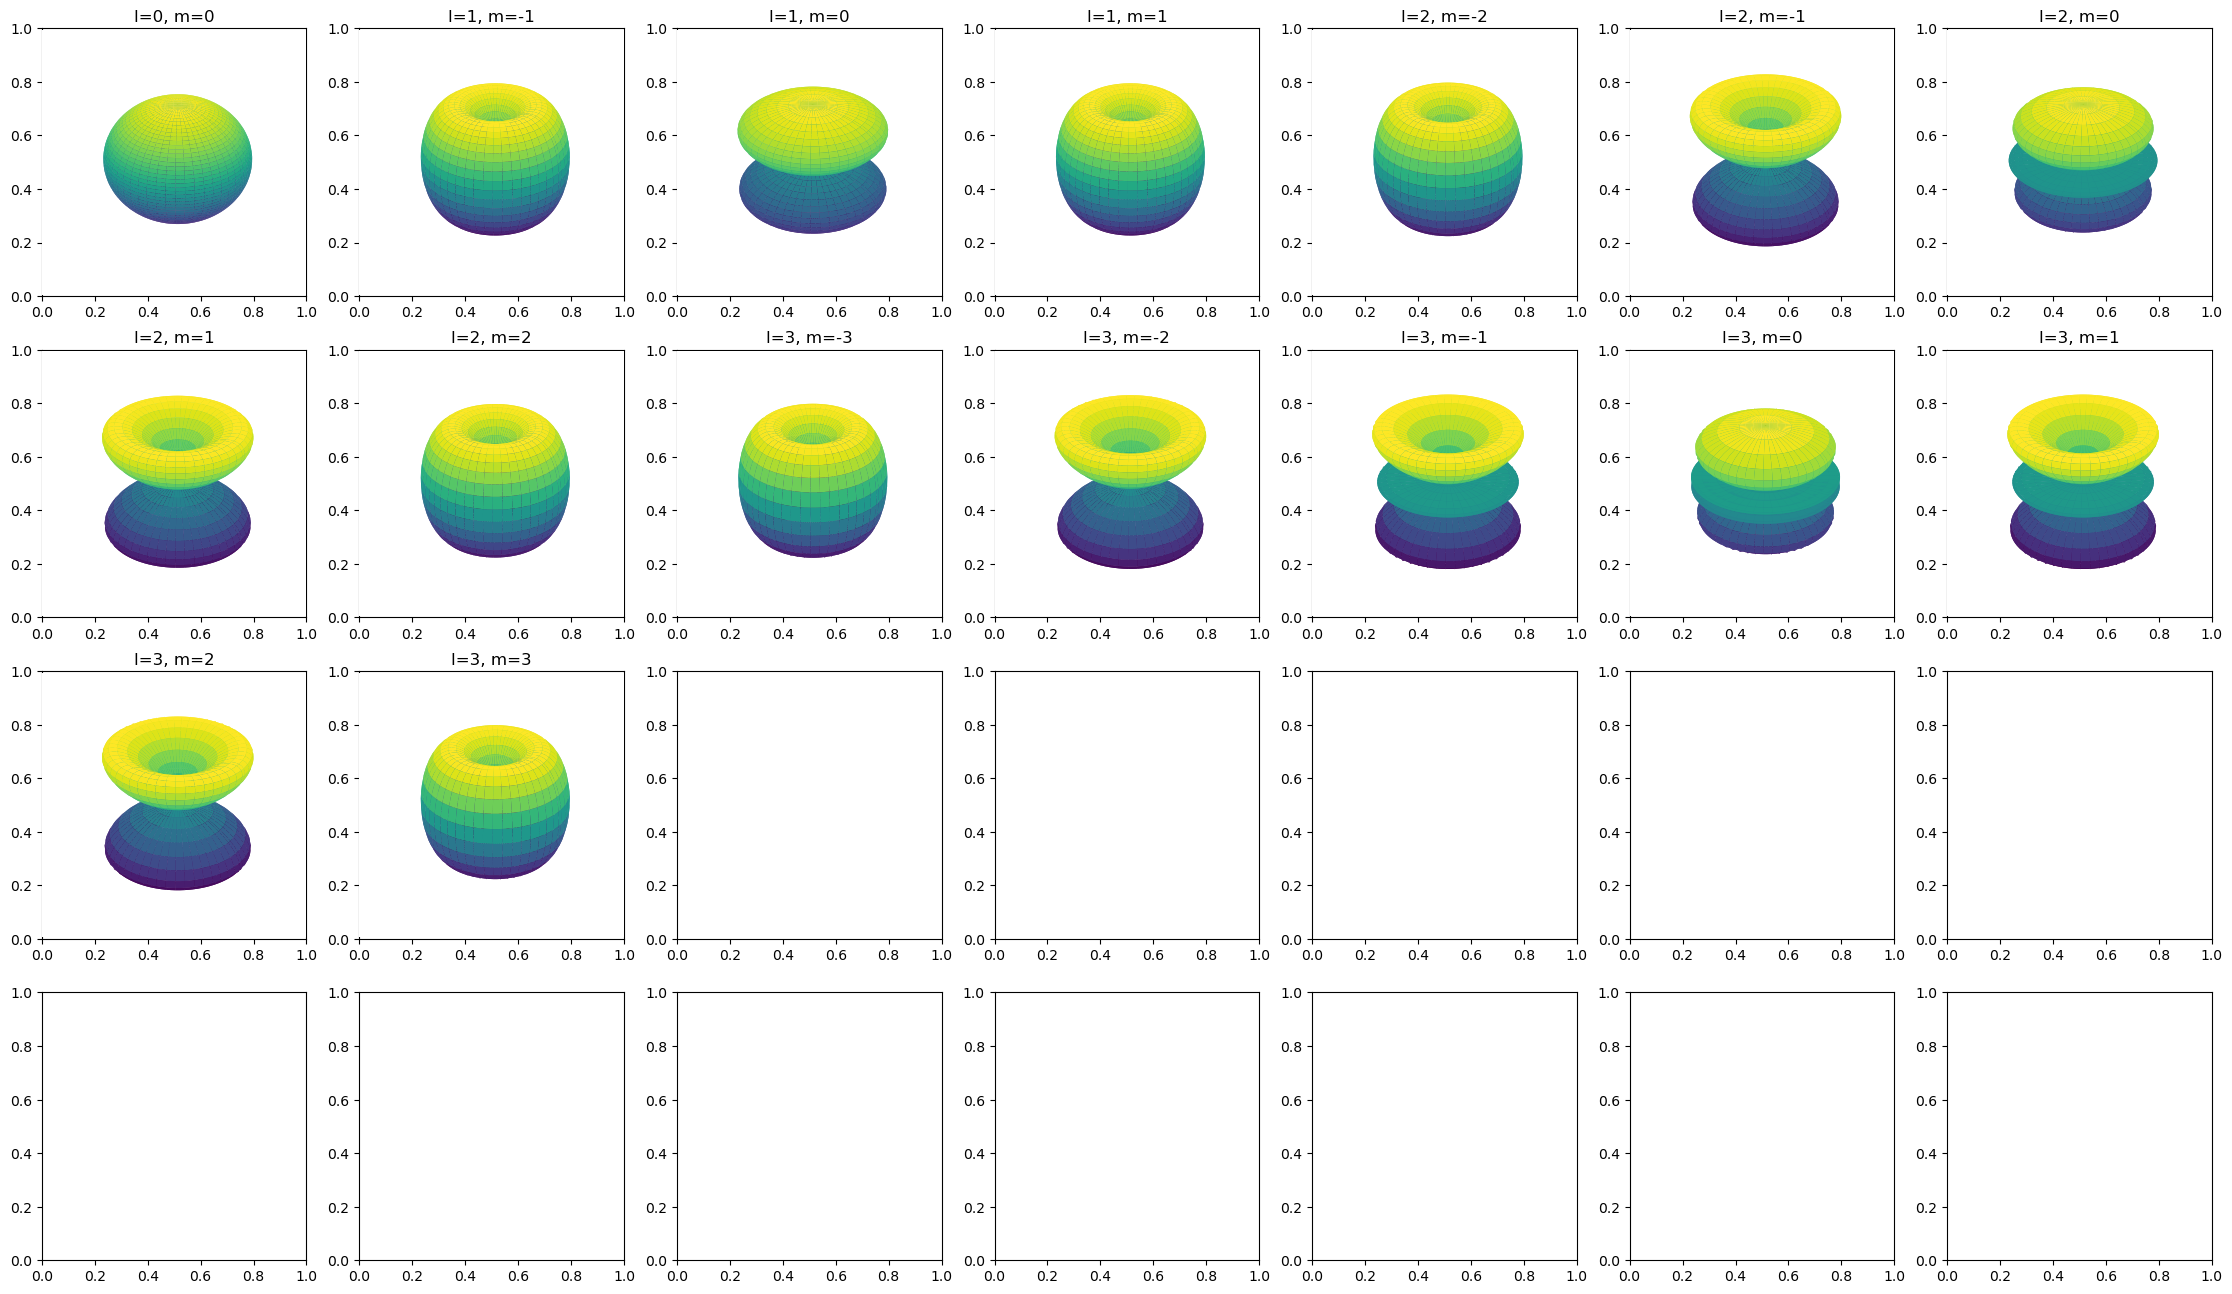

In [65]:
# plot 3d for 2pz (n=2, l=1) orbital

from scipy.special import sph_harm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# plot spherical harmonics for l=0,1,2,3, m=-l,...,l
# use subplots 

ncols = 7
nrows = 4
plt.subplots(nrows,ncols,figsize=(4*ncols,4*nrows))
iplot = 0
for l in range(0,4):
    for m in range(-l,l+1):
        iplot += 1
        ax = plt.subplot(nrows,ncols,iplot,projection='3d')
        phi = np.linspace(0, 2 * np.pi, 100)
        theta = np.linspace(0, np.pi, 100)
        phi, theta = np.meshgrid(phi, theta)
        r = np.abs(sph_harm(m, l, phi, theta))**2
        x = r * np.sin(theta) * np.cos(phi)
        y = r * np.sin(theta) * np.sin(phi)
        z = r * np.cos(theta)
        ax.plot_surface(x, y, z, cmap='viridis')
        ax.set_title(f'l={l}, m={m}')
        ax.set_axis_off()



In [25]:
def fSchrod(En, l, R):
    return l*(l+1.)/R**2-2./R-En

def ComputeSchrod(En,R,l):
    "Computes Schrod Eq." 
    f = fSchrod(En,l,R[::-1])
    ur = Numerovc(f,0.0,-1e-7,-R[1]+R[0])[::-1]
    norm = integrate.simpson(ur**2,x=R)
    return ur*1/np.sqrt(abs(norm))


def Shoot(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    # Because we didn't use the radial from 0 (we started from 1e-6)
    # we want extrapolate u(r) down to r=0 by taking linear extrapolation
    f0,f1 = ur[0],ur[1]
    f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
    return f_at_0

Put it all together is for the homework (see below).

It seems with Numerov we are getting substantial error-bar for the energy of 1s state. We could increase the number of points in the mesh, but the error decreases only linearly with the number of points used.

Where is the problem? What should be done?

In [26]:
R = np.linspace(1e-6,100,5000)
import scipy.optimize as optimize
optimize.brentq(Shoot,-1.1,-0.99,xtol=1e-16,args=(R,0))

-0.9999947296316332

Check that approximate solution gives smaller wave function at zero than exact energy, which confirms that root finding routine works fine.

In [28]:
Shoot(-1.0,R,l=0), Shoot(-0.9999947296316332,R,l=0)

(np.float64(3.9587378768971414e-08), np.float64(4.21907111027367e-18))

Let's check how the function looks like near zero

(-0.2, 0.4)

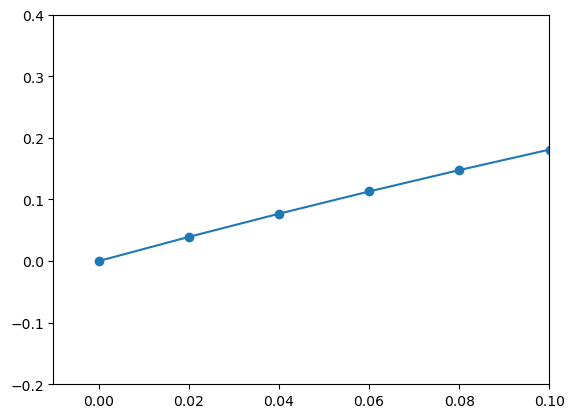

In [35]:
ur = ComputeSchrod(-1.0,R,0)
plt.plot(R,ur,'o-')
plt.xlim(-.01,0.1)
plt.ylim(-0.2,0.4)

Idea: The mesh is very sparse near zero, and in the range of the first few points, the curve is not linear enough. Linear extrapolation gives the error.

Can we do better?

Let's use cubic extrapolation with first 4 points.

In [14]:
help(polyfit)
help(polyval)

NameError: name 'polyfit' is not defined

In [46]:
def Shoot2(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    poly = np.polyfit(R[:4], ur[:4], deg=3)
    return np.polyval(poly, 0.0)

In [45]:
ur = ComputeSchrod(-1.0,R,0)


# u(r=0) of 1s state using linear extrapolation
f0,f1 = ur[0],ur[1]
f_at_0 = f0 + (f1-f0)*(0.0-R[0])/(R[1]-R[0])
print(f_at_0)

# u(r=0) of 1s state using cubic extrapolation
p = np.polyfit(R[:4], ur[:4], deg=3)
print(np.polyval(p, 0))


3.9587378768971414e-08
-9.446698163567071e-12


In [48]:
Shoot(-1,R,l=0), Shoot2(-1,R,l=0)

(np.float64(3.9587378768971414e-08), np.float64(-9.446698163567071e-12))

In [53]:
e1 = optimize.brentq(Shoot,-1.1,-0.9,xtol=1e-16,args=(R,0))
e2 = optimize.brentq(Shoot2,-1.1,-0.9,xtol=1e-16,args=(R,0))
print(e1+1.0,e2+1.0)

5.270368363730071e-06 -1.2612728639282977e-09


Indeed we get $10^{-8}$ error as compared to $10^{-5}$ error before.
So, the extrapolation must be improved to reduce the error.

Increasing the number of points for 10-times reduces the error factor of 1000, i.e., $O(1/N^3)$.

Better cubic extrapolation reduces the error for the same factor of 1000, equivalent to 10-times more points.

In [54]:
R = np.linspace(1e-6,100,2000)
print('Error with linear extrapolation:', optimize.brentq(Shoot,-1.1,-0.9,xtol=1e-16,args=(R,0)) + 1.0 )
print('Error with cubic extrapolation:',  optimize.brentq(Shoot2,-1.1,-0.9,xtol=1e-16,args=(R,0)) + 1.0 )

Error with linear extrapolation: 7.807747000609933e-05
Error with cubic extrapolation: 5.7181167911757314e-08


It also helps to increase the number of points. 10-times denser grid gives roughly $10^{-3}$ smaller error.

In [19]:
R = np.linspace(1e-8,100,20000)
print('Error with linear extrapolation:', optimize.brentq(Shoot,-1.1,-0.9,xtol=1e-16,args=(R,0)) + 1.0 )
print('Error with cubic extrapolation:',  optimize.brentq(Shoot2,-1.1,-0.9,xtol=1e-16,args=(R,0)) + 1.0 )

Error with linear extrapolation: 8.297741005414139e-08
Error with cubic extrapolation: -1.089017764854816e-11


In [55]:
def Numerovc(f, x0, dx, dh):
    """Given precomputed function f(x), solves for x(t), which satisfies:
          x''(t) = f(t) x(t)
          dx = (dx(t)/dt)_{t=0}
          x0 = x(t=0)
    """
    x = np.zeros(len(f))
    x[0] = x0
    x[1] = x0+dh*dx
    h2 = dh**2
    h12 = h2/12.
    w0=x0*(1-h12*f[0])
    w1=x[1]*(1-h12*f[1])
    xi = x[1]
    fi = f[1]
    for i in range(2,f.size):
        w2 = 2*w1-w0+h2*fi*xi  # here fi,xi=f1,x1 at the first step
        fi = f[i]              # at this point fi=f2 in the first step
        xi = w2/(1-h12*fi)     # xi is not x2 in the first step
        x[i]=xi                # save x2 into x[2]
        w0,w1 = w1,w2
    return x

def fSchrod(En, l, R):
    return l*(l+1.)/R**2-2./R-En

def ComputeSchrod(En,R,l):
    "Computes Schrod Eq." 
    f = fSchrod(En,l,R[::-1])
    ur = Numerovc(f,0.0,-1e-7,-R[1]+R[0])[::-1]
    norm = integrate.simpson(ur**2,x=R)
    return ur*1/np.sqrt(abs(norm))

def Shoot(En,R,l):
    ur = ComputeSchrod(En,R,l)
    ur = ur/R**l
    poly = np.polyfit(R[:4], ur[:4], deg=3)
    return np.polyval(poly, 0.0)

def FindBoundStates(R,l,nmax,Esearch):
    n=0
    Ebnd=[]
    u0 = Shoot(Esearch[0],R,l)
    for i in range(1,len(Esearch)):
        u1 = Shoot(Esearch[i],R,l)
        if u0*u1<0:
            Ebound = optimize.brentq(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,args=(R,l))
            #Ebound = optimize.toms748(Shoot,Esearch[i-1],Esearch[i],xtol=1e-16,rtol=3.e-16,args=(R,l))
            Ebnd.append((l,Ebound))
            if len(Ebnd)>nmax: break
            n+=1
            print('Found bound state at E=%14.9f E_exact=%14.9f l=%d' % (Ebound, -1.0/(n+l)**2,l))
        u0=u1
    return Ebnd



In [ ]:
Esearch = -1.2/np.arange(1,20,0.2)**2
R = np.linspace(1e-6,100,2000)

nmax=5
Bnd=[]
for l in range(nmax-1):
    Bnd += FindBoundStates(R,l,nmax-l,Esearch)

Found bound state at E=  -0.999999943 E_exact=  -1.000000000 l=0
Found bound state at E=  -0.249999990 E_exact=  -0.250000000 l=0
Found bound state at E=  -0.111111108 E_exact=  -0.111111111 l=0
Found bound state at E=  -0.062499999 E_exact=  -0.062500000 l=0
Found bound state at E=  -0.039999942 E_exact=  -0.040000000 l=0
Found bound state at E=  -0.249999998 E_exact=  -0.250000000 l=1
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=1
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=1
Found bound state at E=  -0.039999957 E_exact=  -0.040000000 l=1
Found bound state at E=  -0.111111111 E_exact=  -0.111111111 l=2
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=2
Found bound state at E=  -0.039999977 E_exact=  -0.040000000 l=2
Found bound state at E=  -0.062500000 E_exact=  -0.062500000 l=3
Found bound state at E=  -0.039999992 E_exact=  -0.040000000 l=3


## Homework

Compute charge density for atom with Z=28 (Ni), Z=92(U) and Z=94 (Pu).